# Init

In [1]:
# Import utils
import numpy as np
import pandas as pd
import math
import time
import json
import pyreadr
import pickle
from joblib import dump, load
import os
import copy
import datetime

import matplotlib.pyplot as plt

# Load raw data

In [2]:
# Load raw data
data = pd.read_csv('/home/fesc/dddex/PatientScheduling/Data/dataHCScheduling.csv')

In [3]:
# Drop unnecessary columns
data = data.drop(['Unnamed: 0'], axis = 1)

In [4]:
# Format dates and add columns for year, month, ...
for r in range(len(data)):
    
    date = [int(i) for i in reversed(data['Datum'].iloc[r].split('.'))]

    data.loc[r, 'year'] = 2000+date[0]
    data.loc[r, 'month'] = date[1]
    data.loc[r, 'day'] = date[2]
    data.loc[r, 'weekday'] = datetime.date(year=2000+date[0], month=date[1], day=date[2]).weekday
    data.loc[r, 'date'] = datetime.date(year=2000+date[0], month=date[1], day=date[2])
    
data = data.rename(columns = {'KW': 'week'})

In [5]:
# Treatment types
treatments = [
    
    'Bereich_Bronchoskopie', # bronchoscopy
    'Bereich_ERCP',          # endoscopic retrograde cholangiopancreatography
    'Bereich_Endosonographie', # endosonography
    'Bereich_Gastroskopie', # gastroscopy
    'Bereich_Koloskopie' # colonoscopy
    
]

# Room types
rooms = [

    ['Bereich_Bronchoskopie'], # Room A
    ['Bereich_Bronchoskopie', 'Bereich_ERCP', 'Bereich_Gastroskopie', 'Bereich_Koloskopie'], # Room B
    ['Bereich_Bronchoskopie', 'Bereich_Endosonographie', 'Bereich_Gastroskopie', 'Bereich_Koloskopie'], # Room C
    ['Bereich_Gastroskopie'], # Room D
    ['Bereich_Koloskopie'] # Room E

]

In [6]:
# Add treatments to data
treatment = [treatments[i] for i in np.where(np.array(data[treatments]) == 1)[1]]
data['treatment'] = treatment

# Simple EDA

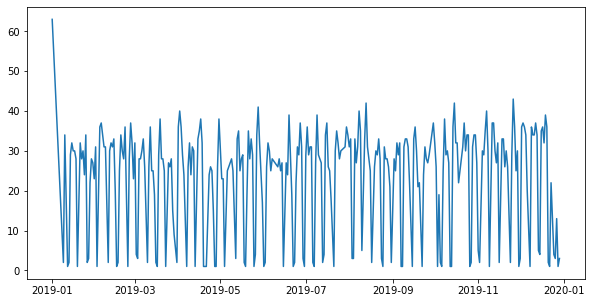

In [8]:
# Number of cases per day
plotData = data.groupby(['date']).agg(M=('patient_id', len)).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
p = ax.plot(plotData['date'], plotData['M'])

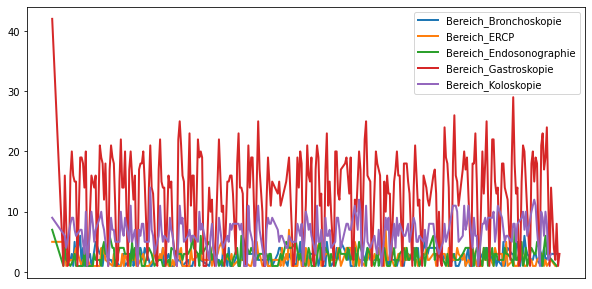

In [9]:
# Number of cases per day by treatment
plotData = data.groupby(['date', 'treatment']).agg(M=('patient_id', len)).reset_index().groupby('treatment')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for treatment, d in plotData:
    ax.plot(d['date'], d.M, marker='', linestyle='-', ms=2, linewidth=2, label=treatment)
ax.legend()
ax.get_xaxis().set_visible(False)
plt.show()

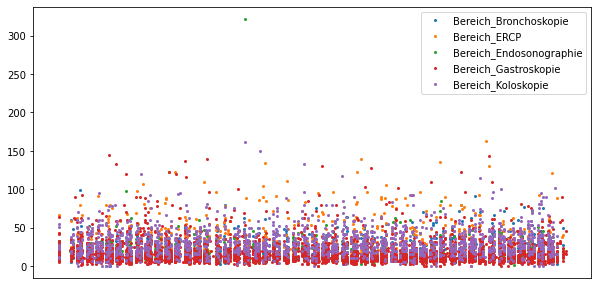

In [10]:
# Duration by treatment
plotData = data.groupby('treatment')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for treatment, d in plotData:
    ax.plot(d['date'], d['Dauer'], marker='o', linestyle='', ms=2, label=treatment)
ax.legend()
ax.get_xaxis().set_visible(False)
plt.show()

In [11]:
# Average number of cases and case duration per day by treatment
data.groupby(['date', 'treatment']).agg(
    n_cases=('patient_id', len),
    duration=('Dauer', np.mean),
).groupby('treatment').agg(
    n_cases=('n_cases', np.mean),
    duration=('duration', np.mean)
).reset_index()

,treatment,n_cases,duration
0,Bereich_Bronchoskopie,2.455357,25.733854
1,Bereich_ERCP,2.290179,42.021227
2,Bereich_Endosonographie,2.739130,20.407522
3,Bereich_Gastroskopie,12.961415,19.147167
4,Bereich_Koloskopie,6.660156,31.334181


In [35]:
# Select a split for training and testing
sel = data.groupby(['date']).agg(
    n_cases=('patient_id', len)
).reset_index().sort_values(by='date')

sel['n_cases'] = sel.n_cases.cumsum()

sel['percent_cases'] = sel.n_cases / max(sel.n_cases)

# Split at
share_train = 0.80

test_start_date = min(sel.loc[sel.percent_cases > share_train].date)

test_start_date

datetime.date(2019, 10, 22)

In [53]:
# Data share over applied split
data['train_test'] = ''
data.loc[data.date < test_start_date, 'train_test'] = 'train'
data.loc[data.date >= test_start_date, 'train_test'] = 'test'

data.groupby(['train_test', 'date']).agg(
    n_cases=('patient_id', len)
).reset_index().groupby('train_test').agg(
    n_cases=('n_cases', sum),
    n_days=('date', len)
).reset_index()

,train_test,n_cases,n_days
0,test,1493,63
1,train,5873,255


# Pre-process data

In [12]:
surgeons = [
    
    'Akpinar',
    'Boehn',
    'Brand',
    'Brand.1', # Duplicate?
    'Bumm',
    'Dick',
    'Döring',
    'Döring.1', # Duplicate?
    'Endres',
    'Engel',
    'Estenfelder',
    'Flemming',
    'Flüchter',
    'Geier',
    'Gernert',
    'Groneberg',
    'Götze',
    'Hann',
    'Hartlapp',
    'Hose',
    'Jung',
    'Kienle',
    'Koscher',
    'Kudlich',
    'Köhler',
    'Lau',
    'Maniuc',
    'Matthes',
    'Megerle',
    'Meining',
    'Meir',
    'Mennig',
    'Mersi',
    'Messerschmidt',
    'Messerschmidt.1', # Duplicate?
    'Nöth',
    'Petri',
    'Pfützner',
    'Plaßmeiner',
    'Purrer',
    'Reibetanz',
    'Reimer',
    'Saam',
    'Scheurlen',
    'Schoettker',
    'Schweinfurth',
    'Seelbach',
    'Smol',
    'Spyglass', # ???
    'Stationsarzt Neuologie', # ???
    'Steinhardt',
    'Stier',
    'Streit',
    'Thiergärtner',
    'Uhlein',
    'Weich',
    'Weiß',
    'Wierlemann',
    'Wiesemann',
    'Yilmaz'
]

In [13]:
codes = [

    '1U047K185',
    '2C738K060',
    '2G411K040',
    '3U048K046',
    '5G402K039',
    'A120031',
    'A120183',
    'A120762',
    'A121432',
    'ASA',
    'CFQ160',
    'ERCP010',
    'ERCP020',
    'ERCP030',
    'ERCP040',
    'ERCP050',
    'ERCP060',
    'ERCP070',
    'ERCP080',
    'ERCP090',
    'ERCP100',
    'ERCP110',
    'ERCP120',
    'ERCP130',
    'ERCP140',
    'EUSOGT010',
    'EUSOGT020',
    'EUSOGT030',
    'EUSUGT010',
    'EUSUGT020',
    'G120515',
    'G120560',
    'G3870',
    'GIFQ180',
    'H121383',
    'H180',
    'H180, H180, H180',
    'HQ190',
    'HQ190, HQ190',
    'INTESTO010',
    'INTESTO040',
    'K120064',
    'KOLO010',
    'KOLO020',
    'KOLO030',
    'KOLO040',
    'KOLO050',
    'KOLO060',
    'KOLO070',
    'KOLO080',
    'KOLO090',
    'KOLO100',
    'KOLO110',
    'KOLO120',
    'KOLO130',
    'KOLO150',
    'KOLO170',
    'OTA',
    'PCFH190',
    'PEG-Kontrolle',
    'PROKTO020',
    'Q180',
    'SPEZ010',
    'TL2900156',
    'ÖGD010',
    'ÖGD020',
    'ÖGD030',
    'ÖGD040',
    'ÖGD050',
    'ÖGD060',
    'ÖGD070',
    'ÖGD080',
    'ÖGD090',
    'ÖGD100',
    'ÖGD110',
    'ÖGD120',
    'ÖGD130',
    'ÖGD140',
    'ÖGD150',
    'ÖGD160',
    'ÖGD170',
    'ÖGD180',
    'ÖGD190',
    'ÖGD200',
    'ÖGD210',
    'ÖGD220',
    'ÖGD230',
    'ÖGD240',
    'ÖGD250',
    'nan'

]

In [14]:
patient = [
    
    'patient_id',
    'Alter',
    'Geschlecht'  
]

In [15]:
case = [
    
    'Dauer',
    
    'year',
    'month',
    'week',
    'day',
    'weekday',
    'date',
    'Datum',
    
    'Monat_1.0',
    'Monat_10.0',
    'Monat_11.0',
    'Monat_12.0',
    'Monat_2.0',
    'Monat_3.0',
    'Monat_4.0',
    'Monat_5.0',
    'Monat_6.0',
    'Monat_7.0',
    'Monat_8.0',
    'Monat_9.0',
    
    'Aufenthalt',
    'Beratung',
    'Hospitant',
    'Notfall',
    
    'Bereich_Bronchoskopie',
    'Bereich_ERCP',
    'Bereich_Endosonographie',
    'Bereich_Gastroskopie',
    'Bereich_Koloskopie',
    
    'treatment'
]

In [16]:
### Create data set

In [23]:
# Feature data
X = data[
    
    # Patient data
    [
        
        'Alter',
        'Geschlecht'  
    
    ] 
    
    +
    
    # Case data
    [

        'month',
        'week',
        'weekday',

        'Aufenthalt',
        'Beratung',
        'Hospitant',
        'Notfall',

        'treatment'
    
    ]

]

In [24]:
# Duration data
Y = data['Dauer']

In [25]:
# ID data
ID = data[
    
    [
    
        'patient_id',
        'date'
        
    ]
]

In [20]:
### Create train-test-split
train = ''
test = ''


